## Load Model

In [1]:
import pandas as pd

df = pd.read_csv("CICIDS2017_2018_Merged_Fuzzy_multiclass.csv")
print("✅ Dataset loaded. Shape:", df.shape)
df.head()


C:\Users\GPU RTX 5000\AppData\Local\Temp\ipykernel_7036\820124170.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CICIDS2017_2018_Merged_Fuzzy_multiclass.csv")


✅ Dataset loaded. Shape: (19063745, 51)


,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,...,Subflow Bwd Bytes,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,86390155,0.0,0.023151,86390155.0,0.0,86390155.0,86390155.0,86390155.0,86390155.0,0.0,...,0,0.0,0.0,0.0,0.0,86390155.0,0.0,86390155.0,86390155.0,benign
1,52687,92375.728358,265.720197,4052.846154,5274.024204,13744.0,1.0,52687.0,7526.714286,5858.263842,...,4356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
2,13,0.0,153846.153846,13.0,0.0,13.0,13.0,13.0,13.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign
3,28199505,39.752471,0.602847,1762469.0625,3294884.039918,12479121.0,31.0,28199505.0,2349958.75,3646632.187841,...,170,9480669.0,0.0,9480669.0,9480669.0,9359418.0,4411926.293176,12479121.0,6239715.0,benign
4,874,742562.929062,8009.153318,145.666667,91.248379,277.0,28.0,481.0,240.5,135.057395,...,488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,benign


Preprocess the data

In [4]:
import numpy as np

# Replace inf/-inf with NaN, then drop those rows
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Align target labels again after row drop
y = y.loc[X.index]


In [5]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# Drop rows with missing values
df = df.dropna()

# Separate features and label
X = df.drop(columns=['Label'])
y = df['Label']

# Convert all columns to numeric, coerce errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaNs
X.dropna(inplace=True)

# Replace inf/-inf with NaN, then drop those too
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# Align target labels
y = y.loc[X.index]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM input: (samples, timesteps, features)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

print("✅ Data prepared successfully:")
print(" - Feature shape:", X_reshaped.shape)
print(" - Label shape:", y_encoded.shape)


✅ Data prepared successfully:
 - Feature shape: (18965059, 1, 50)
 - Label shape: (18965059,)


 Split the dataset

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


Build the LSTM model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Multiclass
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\GPU RTX 5000\Desktop\Major Project Dataset\major\major_merge\myvenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,420 (138.36 KB)

 Trainable params: 35,420 (138.36 KB)

 Non-trainable params: 0 (0.00 B)

 Train the model

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 617s 6ms/step - accuracy: 0.8811 - loss: 0.3454 - val_accuracy: 0.9171 - val_loss: 0.2386
Epoch 2/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 657s 7ms/step - accuracy: 0.9105 - loss: 0.2467 - val_accuracy: 0.9195 - val_loss: 0.2209
Epoch 3/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 646s 7ms/step - accuracy: 0.9160 - loss: 0.2284 - val_accuracy: 0.9204 - val_loss: 0.2053
Epoch 4/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 662s 7ms/step - accuracy: 0.9188 - loss: 0.2198 - val_accuracy: 0.9098 - val_loss: 0.2306
Epoch 5/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 667s 7ms/step - accuracy: 0.9203 - loss: 0.2154 - val_accuracy: 0.9254 - val_loss: 0.1995
Epoch 6/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 675s 7ms/step - accuracy: 0.9214 - loss: 0.2120 - val_accuracy: 0.9262 - val_loss: 0.2033
Epoch 7/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 673s 7ms/step - accuracy: 0.9222 - loss: 0.2095 - val_accuracy: 0.9279 - val_loss: 0.2044
Epoch 8/10
94826/94826 ━━━━━━━━━━━━━━━━━━━━ 671s 7ms/step - ac

 Plot training performance

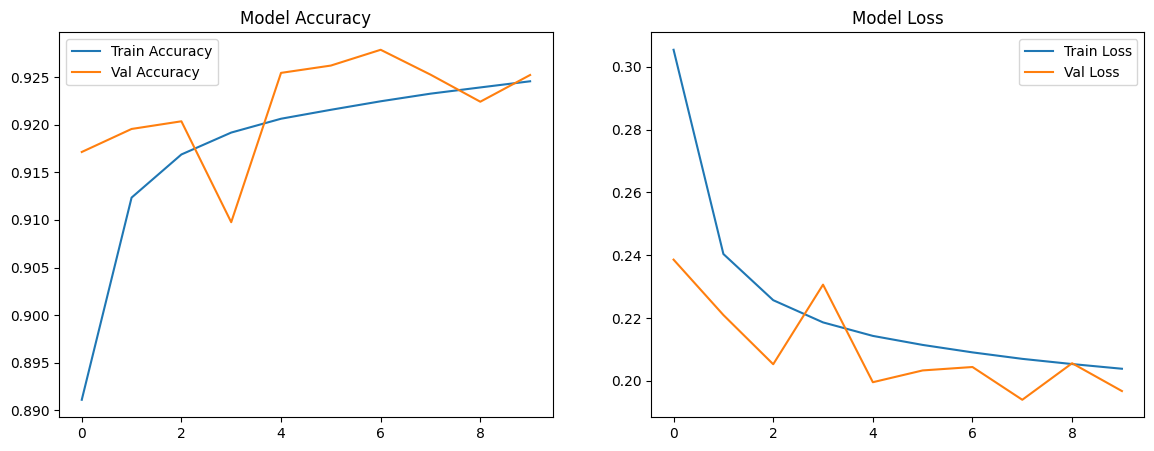

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


Evaluate model

118532/118532 ━━━━━━━━━━━━━━━━━━━━ 426s 4ms/step
🔍 Classification Report:



c:\Users\GPU RTX 5000\Desktop\Major Project Dataset\major\major_merge\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\GPU RTX 5000\Desktop\Major Project Dataset\major\major_merge\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\GPU RTX 5000\Desktop\Major Project Dataset\major\major_merge\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

                          precision    recall  f1-score   support

                  benign       0.98      0.97      0.97   3132314
                     bot       0.75      0.99      0.85     57629
         brute_force_web       1.00      0.21      0.35       122
         brute_force_xss       1.00      0.43      0.61        46
                    ddos       0.99      0.85      0.92     25605
        ddos_attack_hoic       0.45      0.97      0.61    137203
    ddos_attack_loic_udp       0.86      0.50      0.63       346
  ddos_attacks_loic_http       0.98      0.92      0.95    115238
   dos_attacks_goldeneye       0.85      0.62      0.72      8302
        dos_attacks_hulk       0.95      0.05      0.10     92383
dos_attacks_slowhttptest       0.67      0.43      0.52     27978
   dos_attacks_slowloris       0.85      0.71      0.77      2198
           dos_goldeneye       0.99      0.69      0.81      2059
                dos_hulk       0.88      0.83      0.86     46025
        d

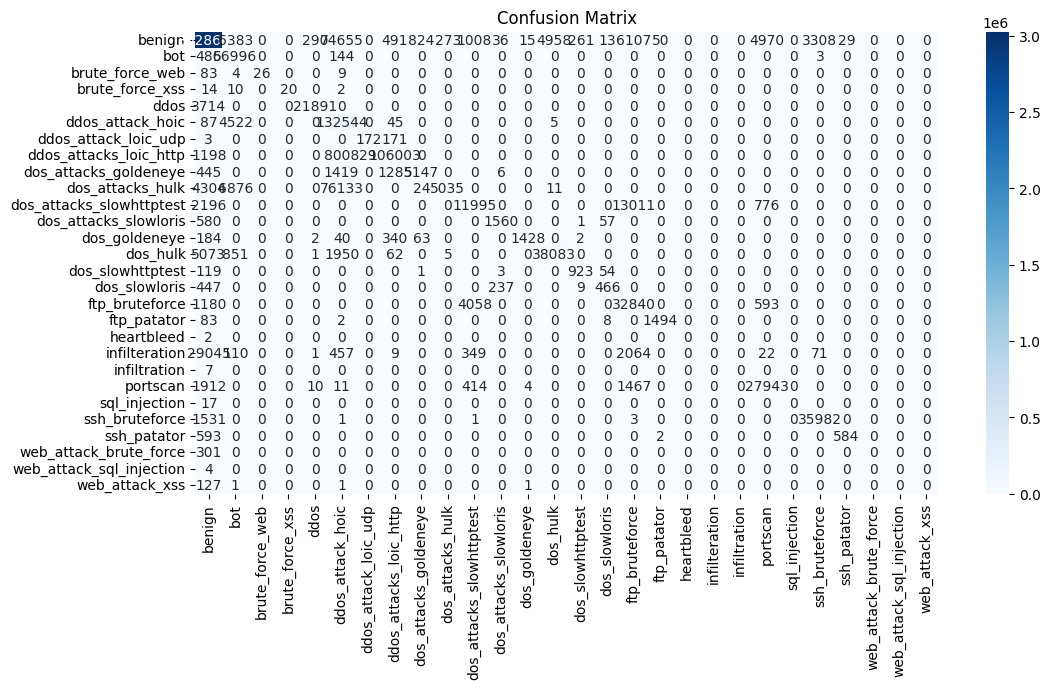

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred = model.predict(X_test).argmax(axis=1)

# Metrics
print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [15]:
# Save the trained model
model.save('lstm_model.h5')
print("✅ Model saved as 'lstm_model.h5'")



✅ Model saved as 'lstm_model.h5'


In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('lstm_model.h5')
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [17]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print evaluation metrics
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


118532/118532 ━━━━━━━━━━━━━━━━━━━━ 754s 6ms/step - accuracy: 0.9253 - loss: 0.1964
Test Loss: 0.19620941579341888
Test Accuracy: 0.9253266453742981


## Binary

In [1]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
# === LOAD DATA ===
df = pd.read_csv("CICIDS2017_2018_Merged_Fuzzy_binary.csv")

# === DROP NA and convert columns ===
df = df.dropna()  # Drop rows with any missing values
X = df.drop(columns=["Label"])

# === Handle Infinite or Extremely Large Values ===
X = X.replace([np.inf, -np.inf], np.nan)  # Replace infinity values with NaN
X = X.dropna()  # Drop any rows that have NaN after replacing infinity values

# Convert all features to numeric values
X = X.apply(pd.to_numeric, errors="coerce")

# === HANDLE REMAINING NA ===
X = X.dropna()  # Drop any remaining rows with NaN values

# === Target Labels ===
y = df.loc[X.index, "Label"]


C:\Users\GPU RTX 5000\AppData\Local\Temp\ipykernel_14028\3112395574.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CICIDS2017_2018_Merged_Fuzzy_binary.csv")


In [5]:
# === HANDLE INFINITY AND LARGE VALUES ===
import numpy as np

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any remaining NaNs in the features
if X.isnull().sum().sum() > 0:
    print(f"Warning: There are still missing values after replacing infinity.")
    X = X.dropna()  # Drop any rows with NaNs if present

# Optionally: Handle large values
# Apply log transformation for positive values
X = X.applymap(lambda x: np.log(x) if x > 0 else x)

# Clip extreme values if needed
X = X.clip(lower=-1000, upper=1000)

# === SCALE FEATURES ===
scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)

print("Features scaled successfully!")

C:\Users\GPU RTX 5000\AppData\Local\Temp\ipykernel_14028\2104655422.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: np.log(x) if x > 0 else x)


Features scaled successfully!


In [9]:
# === ENCODE LABELS === 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)



ValueError: Found input variables with inconsistent numbers of samples: [18965059, 18966925]

In [ ]:
# === BUILD LSTM MODEL ===
model = Sequential()

# Add LSTM layer
model.add(LSTM(64, return_sequences=False, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Add output layer for binary classification
model.add(Dense(1, activation='sigmoid'))


In [ ]:
# === COMPILE THE MODEL ===
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# === CALLBACK FOR SAVING BEST MODEL ===
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [ ]:
# === TRAIN THE MODEL ===
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[checkpoint])


In [ ]:
# === EVALUATE THE MODEL ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


In [ ]:
# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Save the plot as an image
plt.savefig('training_history.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

plt.show()


In [ ]:
# === PLOT CONFUSION MATRIX ===
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the confusion matrix plot as an image
plt.savefig('confusion_matrix.png')  # Save the confusion matrix as a PNG file
plt.show()  # Display the confusion matrix plot


In [11]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# === LOAD DATA ===
df = pd.read_csv("CICIDS2017_2018_Merged_Fuzzy_binary.csv")

# === DROP NA and convert columns ===
df = df.dropna()
X = df.drop(columns=["Label"])
X = X.apply(pd.to_numeric, errors="coerce")
X = X.dropna()
y = df.loc[X.index, "Label"]

# === HANDLE INFINITY AND LARGE VALUES ===
import numpy as np

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any remaining NaNs in the features
if X.isnull().sum().sum() > 0:
    print(f"Warning: There are still missing values after replacing infinity.")
    X = X.dropna()  # Drop any rows with NaNs if present

# Optionally: Handle large values
# Apply log transformation for positive values
X = X.applymap(lambda x: np.log(x) if x > 0 else x)

# Clip extreme values if needed
X = X.clip(lower=-1000, upper=1000)

# === SCALE FEATURES ===
scaler = MinMaxScaler()

# Scale the features
X_scaled = scaler.fit_transform(X)

# === ENCODE LABELS === 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# === ENSURE ALIGNMENT ===
y = y.loc[X.index]  # Ensure that y is aligned with X

# === TRAIN-TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# === DEFINE LSTM MODEL ===
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multiclass classification

# === COMPILE MODEL ===
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === CALLBACKS ===
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# === TRAIN THE MODEL ===
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

# === EVALUATE THE MODEL ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# === PREDICTIONS ===
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary labels (0 or 1)

# === CONFUSION MATRIX AND CLASSIFICATION REPORT ===
print("Classification Report:")
print(classification_report(y_test, y_pred))

# === SAVE RESULTS ===
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Attack"], yticklabels=["Benign", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_binary.png")  # Save image of confusion matrix

# Save classification report to text file
with open("classification_report_binary.txt", "w") as f:
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred))

# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(8, 6))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("model_accuracy_binary.png")  # Save image of accuracy plot

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("model_loss_binary.png")  # Save image of loss plot

print("Training and evaluation complete, images saved!")


C:\Users\GPU RTX 5000\AppData\Local\Temp\ipykernel_14028\312960365.py:15: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CICIDS2017_2018_Merged_Fuzzy_binary.csv")


C:\Users\GPU RTX 5000\AppData\Local\Temp\ipykernel_14028\312960365.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: np.log(x) if x > 0 else x)


ValueError: Found input variables with inconsistent numbers of samples: [18965059, 19002607]